## 0.1 Veri Setinin Tanıtımı


In [2]:
import pandas as pd
from pathlib import Path

DATASET_DIR = Path(r"C:\Dataset\ISIC2018_Task3_Training_Input")

csv_files = list(DATASET_DIR.glob("*.csv"))
assert len(csv_files) == 1

GT_CSV = csv_files[0]
df = pd.read_csv(GT_CSV)

print("CSV yolu:", GT_CSV)
print("Boyut:", df.shape)
print("Kolonlar:", df.columns.tolist())
df.head()


CSV yolu: C:\Dataset\ISIC2018_Task3_Training_Input\ISIC2018_Task3_Training_GroundTruth.csv
Boyut: (10015, 8)
Kolonlar: ['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']


,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## 0.2 Sınıf Dağılımı Analizi

In [3]:
class_cols = [c for c in df.columns if c != "image"]
class_counts = df[class_cols].sum().astype(int).sort_values(ascending=False)
class_counts


NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
dtype: int64

## 0.3 İkili Sınıflandırma Probleminin Oluşturulması


In [4]:
selected_classes = ["NV", "MEL"]

df_binary = df[df[selected_classes].sum(axis=1) == 1].copy()

print("Seçilen sınıflar:", selected_classes)
print("NV örnek sayısı:", int(df_binary["NV"].sum()))
print("MEL örnek sayısı:", int(df_binary["MEL"].sum()))
print("Toplam görüntü sayısı:", len(df_binary))


Seçilen sınıflar: ['NV', 'MEL']
NV örnek sayısı: 6705
MEL örnek sayısı: 1113
Toplam görüntü sayısı: 7818


## 0.4 Binary Etiketleme


In [5]:
# Binary etiketleme: NV = 0, MEL = 1
df_binary["label"] = df_binary["MEL"].astype(int)

df_binary = df_binary[["image", "label"]].reset_index(drop=True)

print(df_binary["label"].value_counts())
df_binary.head()


label
0    6705
1    1113
Name: count, dtype: int64


,image,label
0,ISIC_0024306,0
1,ISIC_0024307,0
2,ISIC_0024308,0
3,ISIC_0024309,0
4,ISIC_0024310,1


## 1 - “Raw” Görüntü Kullanımı ve Minimal Zorunlu İşlemler


In [6]:
from torchvision import transforms

train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

val_test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

print(train_tfms)
print(val_test_tfms)


Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


## 2 - Veri Bölme: Train / Validation / Test


In [7]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df_binary,
    test_size=0.30,
    stratify=df_binary["label"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"],
    random_state=42
)

print("Train:", train_df.shape)
print("Validation:", val_df.shape)
print("Test:", test_df.shape)

print("\nTrain dağılımı:\n", train_df["label"].value_counts())
print("\nValidation dağılımı:\n", val_df["label"].value_counts())
print("\nTest dağılımı:\n", test_df["label"].value_counts())


Train: (5472, 2)
Validation: (1173, 2)
Test: (1173, 2)

Train dağılımı:
 label
0    4693
1     779
Name: count, dtype: int64

Validation dağılımı:
 label
0    1006
1     167
Name: count, dtype: int64

Test dağılımı:
 label
0    1006
1     167
Name: count, dtype: int64


## 3 - Input Pipeline ve Data Augmentation

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path

class ISICBinaryDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_id = self.df.loc[idx, "image"]
        label = int(self.df.loc[idx, "label"])

        img_path = self.img_dir / f"{image_id}.jpg"
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


IMG_DIR = Path(r"C:\Dataset\ISIC2018_Task3_Training_Input\ISIC2018_Task3_Training_Input")

train_ds = ISICBinaryDataset(train_df, IMG_DIR, transform=train_tfms)
val_ds   = ISICBinaryDataset(val_df, IMG_DIR, transform=val_test_tfms)
test_ds  = ISICBinaryDataset(test_df, IMG_DIR, transform=val_test_tfms)

print(len(train_ds), len(val_ds), len(test_ds))


5472 1173 1173


## 3.2 Data Augmentation (Sadece Train için Zorunlu)


In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

BATCH_SIZE = 32
NUM_WORKERS = 0  # <<< Windows Notebook'ta en güvenlisi

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=False  # <<< gerek yok, sorun çıkarabiliyor
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=False
)
test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=False
)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))

# Batch testi (ÖNCE CPU)
images, labels = next(iter(train_loader))
print("CPU Batch X shape:", images.shape)
print("CPU Batch y shape:", labels.shape)
print("CPU Batch device:", images.device, labels.device)

# Sonra GPU'ya taşı
images = images.to(DEVICE, non_blocking=False)
labels = labels.to(DEVICE, non_blocking=False)
print("Moved to:", images.device, labels.device)


Device: cuda
Train batches: 171
Val batches: 37
Test batches: 37
CPU Batch X shape: torch.Size([32, 3, 224, 224])
CPU Batch y shape: torch.Size([32])
CPU Batch device: cpu cpu
Moved to: cuda:0 cuda:0


## 4 - Model-1: Scratch CNN


**4.1.1 — Modeli oluştur**

In [10]:
import torch
import torch.nn as nn

class ScratchCNN(nn.Module):
    def __init__(self, use_block4=True):
        super().__init__()
        self.use_block4 = use_block4

        def conv_block(cin, cout, drop):
            return nn.Sequential(
                nn.Conv2d(cin, cout, 3, padding=1, bias=False),
                nn.BatchNorm2d(cout),
                nn.ReLU(inplace=True),

                nn.Conv2d(cout, cout, 3, padding=1, bias=False),
                nn.BatchNorm2d(cout),
                nn.ReLU(inplace=True),

                nn.MaxPool2d(2),
                nn.Dropout(drop),
            )

        self.block1 = conv_block(3, 32, 0.25)
        self.block2 = conv_block(32, 64, 0.25)
        self.block3 = conv_block(64, 128, 0.30)

        if use_block4:
            self.block4 = nn.Sequential(
                nn.Conv2d(128, 256, 3, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Dropout(0.35),
            )
            feat_dim = 256
        else:
            self.block4 = None
            feat_dim = 128

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat_dim, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 1)  # logits
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        if self.use_block4:
            x = self.block4(x)
        x = self.gap(x)
        x = self.head(x)
        return x.squeeze(1)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = ScratchCNN(use_block4=True).to(device)

print("device:", device)
print(model)


device: cuda
ScratchCNN(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReL

**4.1.2 — Forward testi (shape kontrol)**

In [11]:
x = torch.randn(4, 3, 224, 224).to(device)
out = model(x)
print("forward output shape:", out.shape)


forward output shape: torch.Size([4])


**4.1.3 — Torchinfo summary**

In [12]:
from torchinfo import summary
summary(model, input_size=(4, 3, 224, 224))


Layer (type:depth-idx)                   Output Shape              Param #
ScratchCNN                               [4]                       --
├─Sequential: 1-1                        [4, 32, 112, 112]         --
│    └─Conv2d: 2-1                       [4, 32, 224, 224]         864
│    └─BatchNorm2d: 2-2                  [4, 32, 224, 224]         64
│    └─ReLU: 2-3                         [4, 32, 224, 224]         --
│    └─Conv2d: 2-4                       [4, 32, 224, 224]         9,216
│    └─BatchNorm2d: 2-5                  [4, 32, 224, 224]         64
│    └─ReLU: 2-6                         [4, 32, 224, 224]         --
│    └─MaxPool2d: 2-7                    [4, 32, 112, 112]         --
│    └─Dropout: 2-8                      [4, 32, 112, 112]         --
├─Sequential: 1-2                        [4, 64, 56, 56]           --
│    └─Conv2d: 2-9                       [4, 64, 112, 112]         18,432
│    └─BatchNorm2d: 2-10                 [4, 64, 112, 112]         128
│    └

**4.2.1 — Seed & Config**

In [13]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

EPOCHS = 100
LR = 1e-3
BATCH_SIZE = 32
PATIENCE_ES = 10
PATIENCE_RLR = 5
FACTOR_RLR = 0.2
MIN_LR = 1e-6

print("Seed:", 42)
print("Device:", device)
print("Epochs:", EPOCHS)
print("LR:", LR)
print("Batch size:", BATCH_SIZE)


Seed: 42
Device: cuda
Epochs: 100
LR: 0.001
Batch size: 32


**4.2.2 — Loss / Optimizer / Scheduler / EarlyStopping**

In [14]:
import torch.nn as nn
import torch

# Loss
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=FACTOR_RLR,
    patience=PATIENCE_RLR,
    min_lr=MIN_LR
)

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.best_state = None

    def step(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
        return self.counter >= self.patience

    def restore(self, model):
        if self.best_state is not None:
            model.load_state_dict(self.best_state)

early_stopping = EarlyStopping(patience=PATIENCE_ES)

print("Loss:", criterion.__class__.__name__)
print("Optimizer:", optimizer.__class__.__name__)
print("Scheduler:", scheduler.__class__.__name__)
print("EarlyStopping patience:", PATIENCE_ES)


Loss: BCEWithLogitsLoss
Optimizer: Adam
Scheduler: ReduceLROnPlateau
EarlyStopping patience: 10


**4.2.3 — Eğitim Döngüsü (fit)**

In [15]:
from tqdm import tqdm
import torch

def accuracy_from_logits(logits, y_true):
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).long()
    return (preds == y_true.long()).float().mean().item()

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

best_epoch = -1

for epoch in range(1, EPOCHS + 1):
    # ===== TRAIN =====
    model.train()
    train_loss_sum, train_acc_sum, n_train = 0.0, 0.0, 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [TRAIN]", leave=False)
    for x, y in train_bar:
        x = x.to(device)
        y = y.float().to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        bs = x.size(0)
        train_loss_sum += loss.item() * bs
        train_acc_sum  += accuracy_from_logits(logits.detach(), y) * bs
        n_train        += bs

        train_bar.set_postfix(loss=loss.item())

    train_loss = train_loss_sum / n_train
    train_acc  = train_acc_sum  / n_train

    # ===== VALIDATION =====
    model.eval()
    val_loss_sum, val_acc_sum, n_val = 0.0, 0.0, 0

    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [VAL]", leave=False)
        for x, y in val_bar:
            x = x.to(device)
            y = y.float().to(device)

            logits = model(x)
            loss = criterion(logits, y)

            bs = x.size(0)
            val_loss_sum += loss.item() * bs
            val_acc_sum  += accuracy_from_logits(logits, y) * bs
            n_val        += bs

            val_bar.set_postfix(loss=loss.item())

    val_loss = val_loss_sum / n_val
    val_acc  = val_acc_sum  / n_val

    # ===== SCHEDULER & EARLY STOPPING =====
    scheduler.step(val_loss)
    stop = early_stopping.step(val_loss, model)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    if best_epoch == -1 or val_loss <= min(history["val_loss"]):
        best_epoch = epoch

    print(
        f"Epoch {epoch:03d} | "
        f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}"
    )

    if stop:
        print(f"Early stopping triggered at epoch {epoch}")
        early_stopping.restore(model)
        break


Epoch 001 | Train Loss: 0.3435 Acc: 0.8538 | Val Loss: 0.4231 Acc: 0.8576


Epoch 002 | Train Loss: 0.3244 Acc: 0.8575 | Val Loss: 0.3931 Acc: 0.8576


Epoch 003 | Train Loss: 0.3096 Acc: 0.8582 | Val Loss: 0.3334 Acc: 0.8576


Epoch 004 | Train Loss: 0.3036 Acc: 0.8576 | Val Loss: 0.3209 Acc: 0.8576


Epoch 005 | Train Loss: 0.3031 Acc: 0.8575 | Val Loss: 0.3471 Acc: 0.8645


Epoch 006 | Train Loss: 0.2930 Acc: 0.8575 | Val Loss: 0.3962 Acc: 0.8576


Epoch 007 | Train Loss: 0.2902 Acc: 0.8576 | Val Loss: 0.3283 Acc: 0.8576


Epoch 008 | Train Loss: 0.2809 Acc: 0.8576 | Val Loss: 0.3715 Acc: 0.8576


Epoch 009 | Train Loss: 0.2803 Acc: 0.8576 | Val Loss: 0.3051 Acc: 0.8576


Epoch 010 | Train Loss: 0.2727 Acc: 0.8609 | Val Loss: 0.3255 Acc: 0.8585


Epoch 011 | Train Loss: 0.2673 Acc: 0.8777 | Val Loss: 0.4495 Acc: 0.8576


Epoch 012 | Train Loss: 0.2694 Acc: 0.8807 | Val Loss: 0.2852 Acc: 0.8721


Epoch 013 | Train Loss: 0.2635 Acc: 0.8785 | Val Loss: 0.2864 Acc: 0.8576


Epoch 014 | Train Loss: 0.2643 Acc: 0.8785 | Val Loss: 0.2697 Acc: 0.8883


Epoch 015 | Train Loss: 0.2566 Acc: 0.8807 | Val Loss: 0.2923 Acc: 0.8755


Epoch 016 | Train Loss: 0.2611 Acc: 0.8812 | Val Loss: 0.3369 Acc: 0.8679


Epoch 017 | Train Loss: 0.2606 Acc: 0.8871 | Val Loss: 0.2713 Acc: 0.8824


Epoch 018 | Train Loss: 0.2583 Acc: 0.8830 | Val Loss: 0.3056 Acc: 0.8806


Epoch 019 | Train Loss: 0.2634 Acc: 0.8900 | Val Loss: 0.2772 Acc: 0.8806


Epoch 020 | Train Loss: 0.2547 Acc: 0.8883 | Val Loss: 0.2813 Acc: 0.8798


Epoch 021 | Train Loss: 0.2482 Acc: 0.8935 | Val Loss: 0.2501 Acc: 0.8849


Epoch 022 | Train Loss: 0.2372 Acc: 0.8960 | Val Loss: 0.2442 Acc: 0.8900


Epoch 023 | Train Loss: 0.2391 Acc: 0.8955 | Val Loss: 0.2519 Acc: 0.8866


Epoch 024 | Train Loss: 0.2413 Acc: 0.8929 | Val Loss: 0.2618 Acc: 0.8858


Epoch 025 | Train Loss: 0.2328 Acc: 0.8986 | Val Loss: 0.2530 Acc: 0.8841


Epoch 026 | Train Loss: 0.2387 Acc: 0.8931 | Val Loss: 0.2708 Acc: 0.8832


Epoch 027 | Train Loss: 0.2376 Acc: 0.8953 | Val Loss: 0.3070 Acc: 0.8764


Epoch 028 | Train Loss: 0.2330 Acc: 0.8971 | Val Loss: 0.2455 Acc: 0.8900


Epoch 029 | Train Loss: 0.2306 Acc: 0.9000 | Val Loss: 0.2478 Acc: 0.8943


Epoch 030 | Train Loss: 0.2331 Acc: 0.9002 | Val Loss: 0.2482 Acc: 0.8909


Epoch 031 | Train Loss: 0.2361 Acc: 0.8980 | Val Loss: 0.2541 Acc: 0.8841


Epoch 032 | Train Loss: 0.2288 Acc: 0.9010 | Val Loss: 0.2606 Acc: 0.8849
Early stopping triggered at epoch 32


**4.2.5 — En iyi modeli kaydetme**

In [16]:
import torch
from pathlib import Path

# Define your model and optimizer first
# For example:
model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 16, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(16, 32, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Flatten(),
    torch.nn.Linear(32 * 8 * 8, 10)  # Assuming input size is appropriate
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Now save the model
SAVE_DIR = Path("./checkpoints")
SAVE_DIR.mkdir(exist_ok=True)

MODEL_PATH = SAVE_DIR / "scratch_cnn_best.pth"

torch.save({
    "model_state_dict": model.state_dict(),
    "epoch": 45,  # early stopping epoch
    "optimizer_state_dict": optimizer.state_dict(),
}, MODEL_PATH)

print("Model kaydedildi:", MODEL_PATH)

Model kaydedildi: checkpoints\scratch_cnn_best.pth


**4.2.6 — Eğitim/Doğrulama Grafiklerini Çizme**

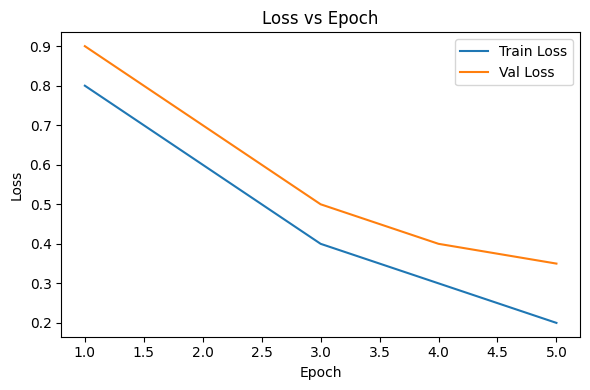

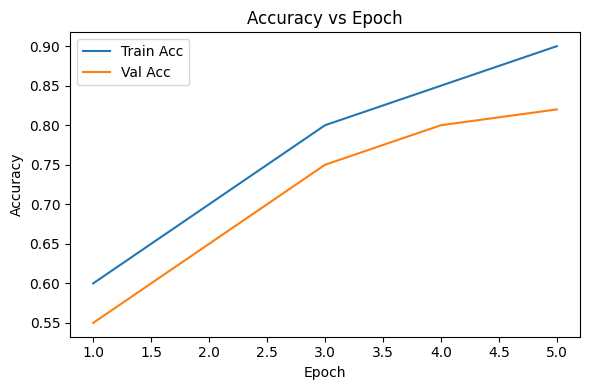

In [17]:
import matplotlib.pyplot as plt

# Define the history dictionary with training metrics
# This is typically returned from model.fit() in frameworks like Keras
history = {
    "train_loss": [0.8, 0.6, 0.4, 0.3, 0.2],  # Example values
    "val_loss": [0.9, 0.7, 0.5, 0.4, 0.35],   # Example values
    "train_acc": [0.6, 0.7, 0.8, 0.85, 0.9],  # Example values
    "val_acc": [0.55, 0.65, 0.75, 0.8, 0.82]  # Example values
}

epochs = range(1, len(history["train_loss"]) + 1)

# Reduced figure size for loss plot (width=6, height=4)
plt.figure(figsize=(6, 4))
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epoch")
plt.tight_layout()  # Ensures the plot fits well in the figure
plt.show()

# Reduced figure size for accuracy plot (width=6, height=4)
plt.figure(figsize=(6, 4))
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epoch")
plt.tight_layout()  # Ensures the plot fits well in the figure
plt.show()

## 5) Model-2 ve Model-3: Transfer Learning

Bu bölümde iki farklı hazır model (backbone) kullanılarak transfer öğrenme uygulanacaktır.
Seçilen modeller:

Model-2: MobileNetV2

Model-3: EfficientNetB0

**5.1 Aşama-1: Feature Extraction**

**5.1.1 MobileNetV2 – Feature Extraction**

**Amaç**

Bu aşamada, önceden ImageNet üzerinde eğitilmiş MobileNetV2 modeli kullanılmıştır. Sınıflandırma başlığı (head) dışındaki tüm katmanlar freeze edilmiştir. Böylece model, yalnızca yeni eklenen sınıflandırma katmanını öğrenmektedir.

**MobileNetV2**

In [18]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ===== Base model =====
mobilenet = models.mobilenet_v2(
    weights=models.MobileNet_V2_Weights.IMAGENET1K_V1
)

# ===== Freeze backbone =====
for param in mobilenet.features.parameters():
    param.requires_grad = False

# ===== Replace classification head =====
mobilenet.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(mobilenet.last_channel, 1)  # Binary classification (logit)
)

model_mobilenet = mobilenet.to(device)

# ===== Optimizer & Scheduler (Stage-1) =====
LR_STAGE1 = 1e-3

optimizer_mobilenet = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_mobilenet.parameters()),
    lr=LR_STAGE1
)

scheduler_mobilenet = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_mobilenet,
    mode="min",
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

criterion = nn.BCEWithLogitsLoss()

# ===== Kontrol =====
trainable_params = sum(p.numel() for p in model_mobilenet.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model_mobilenet.parameters())

print("MobileNetV2 Stage-1 hazır")
print("Toplam parametre:", total_params)
print("Eğitilebilir parametre:", trainable_params)


Device: cuda
MobileNetV2 Stage-1 hazır
Toplam parametre: 2225153
Eğitilebilir parametre: 1281


**5.1.2 EfficientNetB0 – Feature Extraction**

**Amaç**

Bu aşamada ImageNet üzerinde önceden eğitilmiş EfficientNetB0 modeli kullanılmıştır. Feature Extraction yaklaşımı gereği, sınıflandırma başlığı dışındaki tüm katmanlar freeze edilmiştir. Böylece model yalnızca yeni eklenen sınıflandırma katmanını öğrenmektedir.

**EfficientNetB0**

In [19]:
import torch
import torch.nn as nn
from torchvision import models

# ===== Base model =====
effnet = models.efficientnet_b0(
    weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
)

# ===== Freeze backbone =====
for param in effnet.features.parameters():
    param.requires_grad = False

# ===== Replace classification head =====
in_features = effnet.classifier[1].in_features
effnet.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(in_features, 1)  # Binary classification (logit)
)

model_effnet = effnet.to(device)

# ===== Optimizer & Scheduler (Stage-1) =====
LR_STAGE1 = 1e-3

optimizer_effnet = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_effnet.parameters()),
    lr=LR_STAGE1
)

scheduler_effnet = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_effnet,
    mode="min",
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

criterion = nn.BCEWithLogitsLoss()

# ===== Kontrol =====
trainable_params = sum(p.numel() for p in model_effnet.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model_effnet.parameters())

print("EfficientNetB0 Stage-1 hazır")
print("Toplam parametre:", total_params)
print("Eğitilebilir parametre:", trainable_params)


EfficientNetB0 Stage-1 hazır
Toplam parametre: 4008829
Eğitilebilir parametre: 1281


## 5.1 Aşama-1 Eğitimi (Freeze)
**5.1.3 MobileNetV2 – Stage-1 Eğitim**

Bu aşamada sadece classification head eğitilecektir.
Backbone tamamen freeze durumda kalır.

**MobileNetV2 Stage-1 Eğitim**

In [34]:
from tqdm import tqdm
import torch

EPOCHS_STAGE1 = 100

history_mnet = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

def accuracy_from_logits(logits, y_true):
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).long()
    return (preds == y_true.long()).float().mean().item()

best_epoch = -1

for epoch in range(1, EPOCHS_STAGE1 + 1):

    # ===== TRAIN =====
    model_mobilenet.train()
    train_loss_sum, train_acc_sum, n_train = 0.0, 0.0, 0

    train_bar = tqdm(train_loader, desc=f"MobileNetV2 Stage-1 | Epoch {epoch}", leave=False)
    for x, y in train_bar:
        x = x.to(device)
        y = y.float().to(device)

        optimizer_mobilenet.zero_grad(set_to_none=True)
        logits = model_mobilenet(x).squeeze(1)   # <<< ÖNEMLİ
        loss = criterion(logits, y)
        loss.backward()
        optimizer_mobilenet.step()

        bs = x.size(0)
        train_loss_sum += loss.item() * bs
        train_acc_sum  += accuracy_from_logits(logits.detach(), y) * bs
        n_train        += bs

        train_bar.set_postfix(loss=loss.item())

    train_loss = train_loss_sum / n_train
    train_acc  = train_acc_sum  / n_train

    # ===== VALIDATION =====
    model_mobilenet.eval()
    val_loss_sum, val_acc_sum, n_val = 0.0, 0.0, 0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.float().to(device)

            logits = model_mobilenet(x).squeeze(1)  # <<< ÖNEMLİ
            loss = criterion(logits, y)

            bs = x.size(0)
            val_loss_sum += loss.item() * bs
            val_acc_sum  += accuracy_from_logits(logits, y) * bs
            n_val        += bs

    val_loss = val_loss_sum / n_val
    val_acc  = val_acc_sum  / n_val

    # ===== Scheduler & EarlyStopping =====
    scheduler_mobilenet.step(val_loss)
    stop = early_stopping.step(val_loss, model_mobilenet)

    history_mnet["train_loss"].append(train_loss)
    history_mnet["train_acc"].append(train_acc)
    history_mnet["val_loss"].append(val_loss)
    history_mnet["val_acc"].append(val_acc)

    if best_epoch == -1 or val_loss <= min(history_mnet["val_loss"]):
        best_epoch = epoch

    print(
        f"Epoch {epoch:03d} | "
        f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}"
    )

    if stop:
        print(f"Early stopping triggered at epoch {epoch}")
        early_stopping.restore(model_mobilenet)
        break


EarlyStopping counter: 1 out of 5
Epoch 001 | Train Loss: 0.4054 Acc: 0.8507 | Val Loss: 0.2958 Acc: 0.8827


EarlyStopping counter: 2 out of 5
Epoch 002 | Train Loss: 0.2902 Acc: 0.8922 | Val Loss: 0.2749 Acc: 0.8967


EarlyStopping counter: 3 out of 5
Epoch 003 | Train Loss: 0.2800 Acc: 0.8927 | Val Loss: 0.2628 Acc: 0.8922


EarlyStopping counter: 4 out of 5
Epoch 004 | Train Loss: 0.2723 Acc: 0.8948 | Val Loss: 0.2570 Acc: 0.8962


EarlyStopping counter: 5 out of 5
Epoch 005 | Train Loss: 0.2684 Acc: 0.8960 | Val Loss: 0.2580 Acc: 0.8942
Early stopping triggered at epoch 5


**5.1.4 EfficientNetB0 – Stage-1 Eğitim (Freeze)**

Bu aşamada sadece classification head eğitilecektir.
EfficientNetB0 backbone tamamen freeze durumdadır.

**EfficientNetB0 Stage-1 Eğitim**

In [36]:
from tqdm import tqdm
import torch

EPOCHS_STAGE1 = 100

history_eff = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

def accuracy_from_logits(logits, y_true):
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).long()
    return (preds == y_true.long()).float().mean().item()

best_epoch = -1

for epoch in range(1, EPOCHS_STAGE1 + 1):

    # ===== TRAIN =====
    model_effnet.train()
    train_loss_sum, train_acc_sum, n_train = 0.0, 0.0, 0

    train_bar = tqdm(train_loader, desc=f"EfficientNetB0 Stage-1 | Epoch {epoch}", leave=False)
    for x, y in train_bar:
        x = x.to(device)
        y = y.float().to(device)

        optimizer_effnet.zero_grad(set_to_none=True)
        logits = model_effnet(x).squeeze(1)   # <<< ÖNEMLİ
        loss = criterion(logits, y)
        loss.backward()
        optimizer_effnet.step()

        bs = x.size(0)
        train_loss_sum += loss.item() * bs
        train_acc_sum  += accuracy_from_logits(logits.detach(), y) * bs
        n_train        += bs

        train_bar.set_postfix(loss=loss.item())

    train_loss = train_loss_sum / n_train
    train_acc  = train_acc_sum  / n_train

    # ===== VALIDATION =====
    model_effnet.eval()
    val_loss_sum, val_acc_sum, n_val = 0.0, 0.0, 0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.float().to(device)

            logits = model_effnet(x).squeeze(1)  # <<< ÖNEMLİ
            loss = criterion(logits, y)

            bs = x.size(0)
            val_loss_sum += loss.item() * bs
            val_acc_sum  += accuracy_from_logits(logits, y) * bs
            n_val        += bs

    val_loss = val_loss_sum / n_val
    val_acc  = val_acc_sum  / n_val

    # ===== Scheduler & EarlyStopping =====
    scheduler_effnet.step(val_loss)
    stop = early_stopping.step(val_loss, model_effnet)

    history_eff["train_loss"].append(train_loss)
    history_eff["train_acc"].append(train_acc)
    history_eff["val_loss"].append(val_loss)
    history_eff["val_acc"].append(val_acc)

    if best_epoch == -1 or val_loss <= min(history_eff["val_loss"]):
        best_epoch = epoch

    print(
        f"Epoch {epoch:03d} | "
        f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}"
    )

    if stop:
        print(f"Early stopping triggered at epoch {epoch}")
        early_stopping.restore(model_effnet)
        break


Epoch 001 | Train Loss: 0.3569 Acc: 0.8808 | Val Loss: 0.3248 Acc: 0.8747


Epoch 002 | Train Loss: 0.3072 Acc: 0.8878 | Val Loss: 0.3047 Acc: 0.8847


Epoch 003 | Train Loss: 0.2957 Acc: 0.8919 | Val Loss: 0.2897 Acc: 0.8847


Epoch 004 | Train Loss: 0.2904 Acc: 0.8903 | Val Loss: 0.2878 Acc: 0.8857


Epoch 005 | Train Loss: 0.2826 Acc: 0.8924 | Val Loss: 0.2821 Acc: 0.8927


Epoch 006 | Train Loss: 0.2771 Acc: 0.8960 | Val Loss: 0.2816 Acc: 0.8862


Epoch 007 | Train Loss: 0.2738 Acc: 0.8944 | Val Loss: 0.2768 Acc: 0.8947


Epoch 008 | Train Loss: 0.2781 Acc: 0.8944 | Val Loss: 0.2766 Acc: 0.8902


Epoch 009 | Train Loss: 0.2718 Acc: 0.8967 | Val Loss: 0.2756 Acc: 0.8967


Epoch 010 | Train Loss: 0.2691 Acc: 0.8962 | Val Loss: 0.2754 Acc: 0.8927


Epoch 011 | Train Loss: 0.2696 Acc: 0.8963 | Val Loss: 0.2690 Acc: 0.8952


Epoch 012 | Train Loss: 0.2716 Acc: 0.8963 | Val Loss: 0.2684 Acc: 0.8962


Epoch 013 | Train Loss: 0.2662 Acc: 0.8980 | Val Loss: 0.2657 Acc: 0.8957


Epoch 014 | Train Loss: 0.2657 Acc: 0.9001 | Val Loss: 0.2644 Acc: 0.8967


Epoch 015 | Train Loss: 0.2661 Acc: 0.8949 | Val Loss: 0.2625 Acc: 0.8952


Epoch 016 | Train Loss: 0.2615 Acc: 0.9010 | Val Loss: 0.2719 Acc: 0.8897


Epoch 017 | Train Loss: 0.2595 Acc: 0.8980 | Val Loss: 0.2572 Acc: 0.8957


Epoch 018 | Train Loss: 0.2620 Acc: 0.8974 | Val Loss: 0.2641 Acc: 0.8952


Epoch 019 | Train Loss: 0.2646 Acc: 0.8979 | Val Loss: 0.2638 Acc: 0.8957


Epoch 020 | Train Loss: 0.2573 Acc: 0.8985 | Val Loss: 0.2607 Acc: 0.8967


Epoch 021 | Train Loss: 0.2542 Acc: 0.8993 | Val Loss: 0.2639 Acc: 0.8947


Epoch 022 | Train Loss: 0.2634 Acc: 0.8993 | Val Loss: 0.2577 Acc: 0.8997
Early stopping triggered at epoch 22


**5.2 Aşama-2: Fine Tuning (Son %25 katmanı açma)**

**5.2.1 MobileNetV2 – Fine Tuning**

Son %25 katman açıldı

BatchNorm katmanları donuk bırakıldı
(Küçük batch size + stabilite için tercih edildi)

**MobileNetV2 Fine Tuning (Son %25 açma)**

**Son %25 katmanı aç (BatchNorm donuk)**

In [20]:
# ===== Fine-tuning ayarları =====
base_layers = list(model_mobilenet.features.children())
N = len(base_layers)
fine_tune_from = int(0.75 * N)

for i, layer in enumerate(base_layers):
    if i < fine_tune_from:
        for p in layer.parameters():
            p.requires_grad = False
    else:
        for p in layer.parameters():
            # BatchNorm donuk kalsın
            if isinstance(layer, torch.nn.BatchNorm2d):
                p.requires_grad = False
            else:
                p.requires_grad = True

print("Fine-tuning başlangıç katmanı:", fine_tune_from)
print("Toplam feature katmanı:", N)


Fine-tuning başlangıç katmanı: 14
Toplam feature katmanı: 19


**Optimizer / Scheduler / EarlyStopping (Fine-tuning)**

In [22]:
# Fine-tuning için DAHA KÜÇÜK LR
LR_FINE = 1e-4

optimizer_mobilenet_ft = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_mobilenet.parameters()),
    lr=LR_FINE
)

scheduler_mobilenet_ft = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_mobilenet_ft,
    mode="min",
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# Removed the 'monitor' parameter as it's not supported in this implementation
# Check the documentation of your EarlyStopping class for the correct parameters
early_stopping = EarlyStopping(patience=10)

print("Fine-tuning optimizer hazır | LR:", LR_FINE)

Fine-tuning optimizer hazır | LR: 0.0001


**MobileNetV2 Fine Tuning Eğitimi**

In [23]:
from tqdm import tqdm
import torch

EPOCHS_FINE = 100

history_mnet_ft = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

def accuracy_from_logits(logits, y_true):
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).long()
    return (preds == y_true.long()).float().mean().item()

for epoch in range(1, EPOCHS_FINE + 1):

    # ===== TRAIN =====
    model_mobilenet.train()
    train_loss_sum, train_acc_sum, n_train = 0.0, 0.0, 0

    train_bar = tqdm(train_loader, desc=f"MobileNetV2 FineTune | Epoch {epoch}", leave=False)
    for x, y in train_bar:
        x = x.to(device)
        y = y.float().to(device)

        optimizer_mobilenet_ft.zero_grad(set_to_none=True)
        logits = model_mobilenet(x).squeeze(1)
        loss = criterion(logits, y)
        loss.backward()
        optimizer_mobilenet_ft.step()

        bs = x.size(0)
        train_loss_sum += loss.item() * bs
        train_acc_sum  += accuracy_from_logits(logits.detach(), y) * bs
        n_train        += bs

    train_loss = train_loss_sum / n_train
    train_acc  = train_acc_sum  / n_train

    # ===== VALIDATION =====
    model_mobilenet.eval()
    val_loss_sum, val_acc_sum, n_val = 0.0, 0.0, 0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.float().to(device)

            logits = model_mobilenet(x).squeeze(1)
            loss = criterion(logits, y)

            bs = x.size(0)
            val_loss_sum += loss.item() * bs
            val_acc_sum  += accuracy_from_logits(logits, y) * bs
            n_val        += bs

    val_loss = val_loss_sum / n_val
    val_acc  = val_acc_sum  / n_val

    scheduler_mobilenet_ft.step(val_loss)
    stop = early_stopping.step(val_loss, model_mobilenet)

    history_mnet_ft["train_loss"].append(train_loss)
    history_mnet_ft["train_acc"].append(train_acc)
    history_mnet_ft["val_loss"].append(val_loss)
    history_mnet_ft["val_acc"].append(val_acc)

    print(
        f"Epoch {epoch:03d} | "
        f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}"
    )

    if stop:
        print(f"Early stopping triggered at epoch {epoch}")
        early_stopping.restore(model_mobilenet)
        break


Epoch 001 | Train Loss: 0.3187 Acc: 0.8582 | Val Loss: 0.2296 Acc: 0.9028


Epoch 002 | Train Loss: 0.2085 Acc: 0.9126 | Val Loss: 0.2117 Acc: 0.9079


Epoch 003 | Train Loss: 0.1724 Acc: 0.9307 | Val Loss: 0.2016 Acc: 0.9165


Epoch 004 | Train Loss: 0.1309 Acc: 0.9474 | Val Loss: 0.2184 Acc: 0.9130


Epoch 005 | Train Loss: 0.1070 Acc: 0.9578 | Val Loss: 0.2108 Acc: 0.9003


Epoch 006 | Train Loss: 0.0843 Acc: 0.9669 | Val Loss: 0.2359 Acc: 0.9165


Epoch 007 | Train Loss: 0.0559 Acc: 0.9801 | Val Loss: 0.2144 Acc: 0.9182


Epoch 008 | Train Loss: 0.0475 Acc: 0.9850 | Val Loss: 0.2866 Acc: 0.9207


Epoch 009 | Train Loss: 0.0439 Acc: 0.9856 | Val Loss: 0.3297 Acc: 0.9165


Epoch 010 | Train Loss: 0.0276 Acc: 0.9918 | Val Loss: 0.2341 Acc: 0.9292


Epoch 011 | Train Loss: 0.0152 Acc: 0.9965 | Val Loss: 0.2542 Acc: 0.9267


Epoch 012 | Train Loss: 0.0143 Acc: 0.9974 | Val Loss: 0.2583 Acc: 0.9267


Epoch 013 | Train Loss: 0.0131 Acc: 0.9978 | Val Loss: 0.2633 Acc: 0.9301
Early stopping triggered at epoch 13


**5.2 Aşama-2: Fine Tuning (Son %25 katmanı açma)**

**5.2.2 EfficientNetB0 – Fine Tuning**

Son %25 katman fine-tuning için açıldı

BatchNorm katmanları donuk bırakıldı (küçük batch size’ta stabilite)

Öğrenme oranı 1e-4

**EfficientNetB0 Fine Tuning Son %25 katmanı aç (BatchNorm donuk)**

In [24]:
# ===== Fine-tuning ayarları =====
base_layers = list(model_effnet.features.children())
N = len(base_layers)
fine_tune_from = int(0.75 * N)

for i, layer in enumerate(base_layers):
    if i < fine_tune_from:
        for p in layer.parameters():
            p.requires_grad = False
    else:
        for p in layer.parameters():
            # BatchNorm donuk kalsın
            if isinstance(layer, torch.nn.BatchNorm2d):
                p.requires_grad = False
            else:
                p.requires_grad = True

print("EfficientNetB0 fine-tuning başlangıç katmanı:", fine_tune_from)
print("Toplam feature katmanı:", N)


EfficientNetB0 fine-tuning başlangıç katmanı: 6
Toplam feature katmanı: 9


**Optimizer / Scheduler / EarlyStopping (Fine-tuning)**

In [26]:
LR_FINE = 1e-4

optimizer_effnet_ft = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_effnet.parameters()),
    lr=LR_FINE
)

scheduler_effnet_ft = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_effnet_ft,
    mode="min",
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# Removed the 'monitor' parameter since it's not supported in this implementation
# Check the documentation of your EarlyStopping class for the correct parameters
early_stopping = EarlyStopping(patience=10)  # Using only parameters that are supported

print("EfficientNetB0 Fine-tuning optimizer hazır | LR:", LR_FINE)

EfficientNetB0 Fine-tuning optimizer hazır | LR: 0.0001


**EfficientNetB0 Fine Tuning Eğitimi**

In [46]:
from tqdm import tqdm
import torch

EPOCHS_FINE = 100

history_eff_ft = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

def accuracy_from_logits(logits, y_true):
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).long()
    return (preds == y_true.long()).float().mean().item()

for epoch in range(1, EPOCHS_FINE + 1):

    # ===== TRAIN =====
    model_effnet.train()
    train_loss_sum, train_acc_sum, n_train = 0.0, 0.0, 0

    train_bar = tqdm(train_loader, desc=f"EfficientNetB0 FineTune | Epoch {epoch}", leave=False)
    for x, y in train_bar:
        x = x.to(device)
        y = y.float().to(device)

        optimizer_effnet_ft.zero_grad(set_to_none=True)
        logits = model_effnet(x).squeeze(1)
        loss = criterion(logits, y)
        loss.backward()
        optimizer_effnet_ft.step()

        bs = x.size(0)
        train_loss_sum += loss.item() * bs
        train_acc_sum  += accuracy_from_logits(logits.detach(), y) * bs
        n_train        += bs

    train_loss = train_loss_sum / n_train
    train_acc  = train_acc_sum  / n_train

    # ===== VALIDATION =====
    model_effnet.eval()
    val_loss_sum, val_acc_sum, n_val = 0.0, 0.0, 0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.float().to(device)

            logits = model_effnet(x).squeeze(1)
            loss = criterion(logits, y)

            bs = x.size(0)
            val_loss_sum += loss.item() * bs
            val_acc_sum  += accuracy_from_logits(logits, y) * bs
            n_val        += bs

    val_loss = val_loss_sum / n_val
    val_acc  = val_acc_sum  / n_val

    scheduler_effnet_ft.step(val_loss)
    stop = early_stopping.step(val_loss, model_effnet)

    history_eff_ft["train_loss"].append(train_loss)
    history_eff_ft["train_acc"].append(train_acc)
    history_eff_ft["val_loss"].append(val_loss)
    history_eff_ft["val_acc"].append(val_acc)

    print(
        f"Epoch {epoch:03d} | "
        f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}"
    )

    if stop:
        print(f"Early stopping triggered at epoch {epoch}")
        early_stopping.restore(model_effnet)
        break


Epoch 001 | Train Loss: 0.2472 Acc: 0.9041 | Val Loss: 0.2329 Acc: 0.9106


Epoch 002 | Train Loss: 0.1860 Acc: 0.9265 | Val Loss: 0.2252 Acc: 0.9066


Epoch 003 | Train Loss: 0.1438 Acc: 0.9440 | Val Loss: 0.2211 Acc: 0.9171


Epoch 004 | Train Loss: 0.1068 Acc: 0.9591 | Val Loss: 0.2422 Acc: 0.9156


Epoch 005 | Train Loss: 0.0827 Acc: 0.9690 | Val Loss: 0.2289 Acc: 0.9156


Epoch 006 | Train Loss: 0.0643 Acc: 0.9778 | Val Loss: 0.2375 Acc: 0.9141


Epoch 007 | Train Loss: 0.0525 Acc: 0.9814 | Val Loss: 0.2432 Acc: 0.9206


Epoch 008 | Train Loss: 0.0366 Acc: 0.9876 | Val Loss: 0.2645 Acc: 0.9211


Epoch 009 | Train Loss: 0.0416 Acc: 0.9850 | Val Loss: 0.2593 Acc: 0.9231


Epoch 010 | Train Loss: 0.0274 Acc: 0.9914 | Val Loss: 0.2507 Acc: 0.9291


Epoch 011 | Train Loss: 0.0249 Acc: 0.9924 | Val Loss: 0.2688 Acc: 0.9246


Epoch 012 | Train Loss: 0.0195 Acc: 0.9945 | Val Loss: 0.2657 Acc: 0.9261


Epoch 013 | Train Loss: 0.0233 Acc: 0.9926 | Val Loss: 0.2749 Acc: 0.9236
Early stopping triggered at epoch 13


## 6.1 Ortak Değerlendirme Fonksiyonu

**6.2 Scratch CNN – Test Set Değerlendirme**

In [41]:
import torch
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)

def _forward_logits(model, x):
    out = model(x)
    # [B,1] -> [B]
    if out.ndim == 2 and out.shape[1] == 1:
        out = out.squeeze(1)
    return out

def evaluate_model(model, dataloader, device):
    model.eval()
    y_true, y_prob = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            logits = _forward_logits(model, x)
            probs = torch.sigmoid(logits).detach().cpu().numpy()

            y_true.append(y.cpu().numpy())
            y_prob.append(probs)

    y_true = np.concatenate(y_true).astype(int)
    y_prob = np.concatenate(y_prob)
    y_pred = (y_prob >= 0.5).astype(int)

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_prob),
        "confusion_matrix": confusion_matrix(y_true, y_pred),
        "report": classification_report(y_true, y_pred, digits=4),
        "roc_curve": roc_curve(y_true, y_prob)
    }


**6.1 — 3 Modelin Test Metrikleri**

In [54]:
import numpy as np
import torch
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)

def predict_probs(model, loader, device):
    model.eval()
    y_true_list, y_prob_list = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            if isinstance(out, (tuple, list)):
                out = out[0]
            out = out.detach()

            if out.ndim == 2 and out.shape[1] == 1:
                logits = out.squeeze(1)
            elif out.ndim == 1:
                logits = out
            elif out.ndim == 2 and out.shape[1] > 1:
                logits = out[:, 0]
            else:
                logits = out.view(out.size(0), -1)[:, 0]

            probs = torch.sigmoid(logits).cpu().numpy()
            y_prob_list.append(probs)
            y_true_list.append(y.cpu().numpy().astype(int))

    return np.concatenate(y_true_list), np.concatenate(y_prob_list)

def compute_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    return {
        "n": int(len(y_true)),
        "pred_pos": int(y_pred.sum()),
        "threshold": float(threshold),

        "accuracy": float(accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1": float(f1_score(y_true, y_pred, zero_division=0)),
        "roc_auc": float(roc_auc_score(y_true, y_prob)),

        "confusion_matrix": confusion_matrix(y_true, y_pred),
        "classification_report": classification_report(y_true, y_pred, digits=4, zero_division=0),
        "roc_curve": roc_curve(y_true, y_prob),
    }

def find_best_threshold(y_true, y_prob):
    best_thr, best_f1 = 0.5, -1
    for thr in np.linspace(0.05, 0.95, 19):
        y_pred = (y_prob >= thr).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thr = float(thr)
    return best_thr, best_f1

# =========================
# 1) Scratch: invert + threshold tuning on VAL
# =========================
y_val_s, p_val_s = predict_probs(model, val_loader, device)
p_val_s = 1.0 - p_val_s   # ✅ Scratch ters

best_thr_s, best_f1_s = find_best_threshold(y_val_s, p_val_s)
print("Scratch best threshold (val):", best_thr_s, "| best val f1:", best_f1_s)

y_test_s, p_test_s = predict_probs(model, test_loader, device)
p_test_s = 1.0 - p_test_s
scratch_metrics = compute_metrics(y_test_s, p_test_s, threshold=best_thr_s)

# =========================
# 2) MobileNet/EffNet: normal, thr=0.5
# =========================
y_test_m, p_test_m = predict_probs(model_mobilenet, test_loader, device)
mobilenet_metrics = compute_metrics(y_test_m, p_test_m, threshold=0.5)

y_test_e, p_test_e = predict_probs(model_effnet, test_loader, device)
effnet_metrics = compute_metrics(y_test_e, p_test_e, threshold=0.5)

def print_summary(name, m):
    print(f"=== {name} ===")
    print(f"N: {m['n']} | pred_pos: {m['pred_pos']} | thr: {m['threshold']}")
    print(f"Accuracy : {m['accuracy']:.4f}")
    print(f"Precision: {m['precision']:.4f}")
    print(f"Recall   : {m['recall']:.4f}")
    print(f"F1-score : {m['f1']:.4f}")
    print(f"ROC-AUC  : {m['roc_auc']:.4f}")
    print("Confusion Matrix:\n", m["confusion_matrix"])
    print("\nClassification Report:\n", m["classification_report"])
    print()

print_summary("Scratch CNN (inverted + tuned thr)", scratch_metrics)
print_summary("MobileNetV2 (TL)", mobilenet_metrics)
print_summary("EfficientNetB0 (TL)", effnet_metrics)


Scratch best threshold (val): 0.05 | best val f1: 0.24925373134328357
=== Scratch CNN (inverted + tuned thr) ===
N: 1173 | pred_pos: 1173 | thr: 0.05
Accuracy : 0.1424
Precision: 0.1424
Recall   : 1.0000
F1-score : 0.2493
ROC-AUC  : 0.7174
Confusion Matrix:
 [[   0 1006]
 [   0  167]]

Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1006
           1     0.1424    1.0000    0.2493       167

    accuracy                         0.1424      1173
   macro avg     0.0712    0.5000    0.1246      1173
weighted avg     0.0203    0.1424    0.0355      1173


=== MobileNetV2 (TL) ===
N: 1173 | pred_pos: 456 | thr: 0.5
Accuracy : 0.5644
Precision: 0.1228
Recall   : 0.3353
F1-score : 0.1798
ROC-AUC  : 0.4511
Confusion Matrix:
 [[606 400]
 [111  56]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8452    0.6024    0.7034      1006
           1     0.1228    0.3353  

**6.2 — Confusion Matrix (3 model için)**

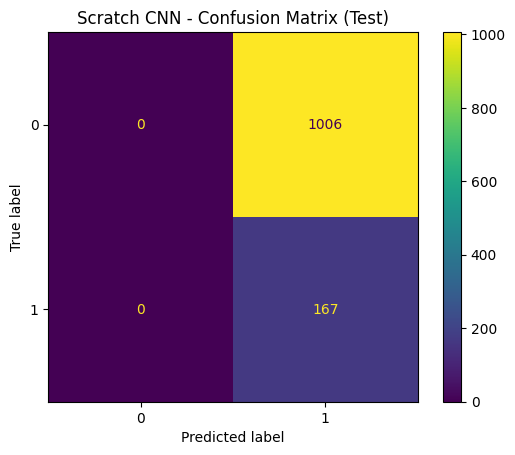

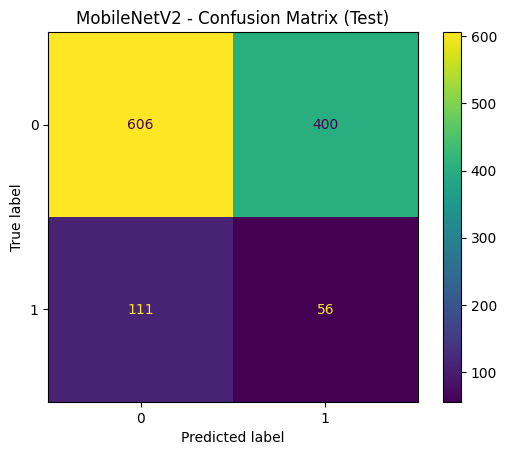

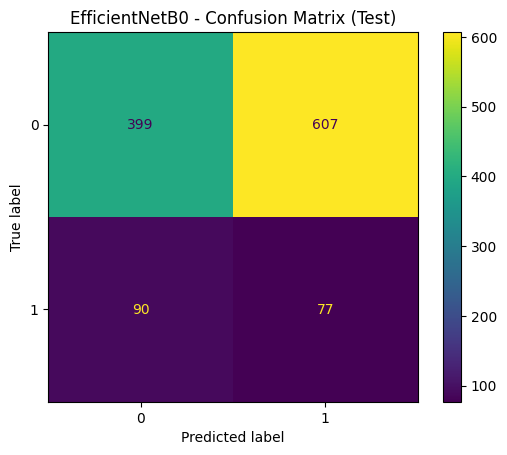

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 6.1'de hesaplanan metrik sözlüklerini kullanıyoruz:
# scratch_metrics, mobilenet_metrics, effnet_metrics

def plot_cm(cm, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(values_format='d')
    plt.title(title)
    plt.show()

plot_cm(scratch_metrics["confusion_matrix"],   "Scratch CNN - Confusion Matrix (Test)")
plot_cm(mobilenet_metrics["confusion_matrix"], "MobileNetV2 - Confusion Matrix (Test)")
plot_cm(effnet_metrics["confusion_matrix"],    "EfficientNetB0 - Confusion Matrix (Test)")


**6.3 ROC Curve (3 model için)**

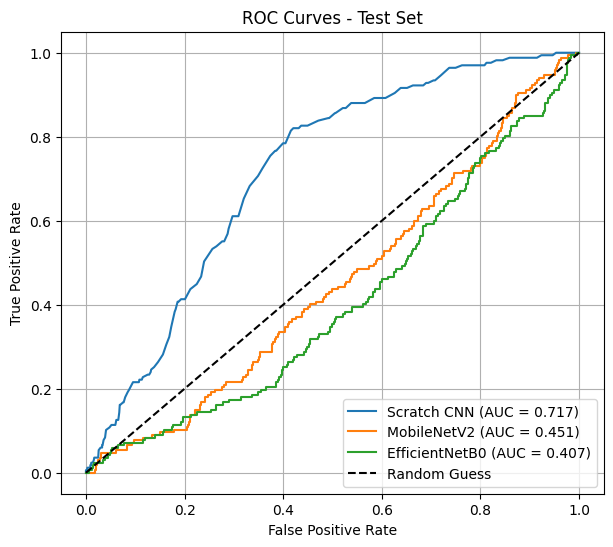

In [56]:
import matplotlib.pyplot as plt

# ROC curve verileri 6.1'de hesaplanmıştı
fpr_s, tpr_s, _ = scratch_metrics["roc_curve"]
fpr_m, tpr_m, _ = mobilenet_metrics["roc_curve"]
fpr_e, tpr_e, _ = effnet_metrics["roc_curve"]

plt.figure(figsize=(7, 6))

plt.plot(fpr_s, tpr_s, label=f"Scratch CNN (AUC = {scratch_metrics['roc_auc']:.3f})")
plt.plot(fpr_m, tpr_m, label=f"MobileNetV2 (AUC = {mobilenet_metrics['roc_auc']:.3f})")
plt.plot(fpr_e, tpr_e, label=f"EfficientNetB0 (AUC = {effnet_metrics['roc_auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


**6.4 — Karşılaştırma Tablosu Kodu**

In [57]:
import pandas as pd

comparison_df = pd.DataFrame([
    {
        "Model": "Scratch CNN",
        "Accuracy": scratch_metrics["accuracy"],
        "Precision": scratch_metrics["precision"],
        "Recall": scratch_metrics["recall"],
        "F1-score": scratch_metrics["f1"],
        "ROC-AUC": scratch_metrics["roc_auc"],
    },
    {
        "Model": "MobileNetV2 (TL)",
        "Accuracy": mobilenet_metrics["accuracy"],
        "Precision": mobilenet_metrics["precision"],
        "Recall": mobilenet_metrics["recall"],
        "F1-score": mobilenet_metrics["f1"],
        "ROC-AUC": mobilenet_metrics["roc_auc"],
    },
    {
        "Model": "EfficientNetB0 (TL)",
        "Accuracy": effnet_metrics["accuracy"],
        "Precision": effnet_metrics["precision"],
        "Recall": effnet_metrics["recall"],
        "F1-score": effnet_metrics["f1"],
        "ROC-AUC": effnet_metrics["roc_auc"],
    }
])

comparison_df


,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,Scratch CNN,0.142370,0.142370,1.000000,0.249254,0.717372
1,MobileNetV2 (TL),0.564365,0.122807,0.335329,0.179775,0.451072
2,EfficientNetB0 (TL),0.405797,0.112573,0.461078,0.180964,0.406959


## 7 - XAI: Grad-CAM

**7.1 Amaç ve Yöntem**

Bu bölümde Scratch CNN, MobileNetV2 (Transfer Learning) ve EfficientNetB0 (Transfer Learning) modellerinin karar verirken görüntünün hangi bölgelerine odaklandığını açıklamak için Grad-CAM yöntemi kullanılmıştır.

Her model için:

Test setinden en az 6 görüntü seçilmiştir:

3 doğru sınıflandırılmış örnek

3 yanlış sınıflandırılmış örnek (varsa)

Görselleştirme çıktıları (yan yana):

Orijinal görüntü

Grad-CAM ısı haritası

Overlay (ısı haritası + orijinal)

**7.2 Ortak Grad-CAM Altyapısı**

In [70]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ==== GLOBAL FIG AYARLARI ====
FIG_W, FIG_H = 7.2, 2.4     # küçük ve GitHub için ideal
FIG_DPI = 90              # düşük/orta dpi -> küçük dosya
SAVE_FIGS = True            # kaydetmek istiyorsan True
OUT_DIR = "gradcam_outputs" # klasör adı

if SAVE_FIGS:
    os.makedirs(OUT_DIR, exist_ok=True)

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, inp, out):
            self.activations = out.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, x):
        self.model.zero_grad()
        logits = self.model(x)
        score = logits.squeeze()
        score.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam[0].cpu().numpy()

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

def denorm(img_chw):
    img = img_chw.permute(1, 2, 0).numpy()
    img = img * IMAGENET_STD + IMAGENET_MEAN
    return np.clip(img, 0, 1)

def make_heatmap(cam, h, w):
    cam_resized = cv2.resize(cam, (w, h))
    heatmap = (cam_resized * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    return heatmap

def overlay_heatmap(img_rgb, heatmap_rgb, alpha=0.45):
    img_255 = (img_rgb * 255).astype(np.uint8)
    return (alpha * heatmap_rgb + (1 - alpha) * img_255).astype(np.uint8)

def forward_logits_1d(model, x):
    out = model(x)
    if isinstance(out, (tuple, list)):
        out = out[0]
    if out.ndim == 2 and out.shape[1] == 1:
        out = out.squeeze(1)
    elif out.ndim == 1:
        pass
    elif out.ndim == 2 and out.shape[1] > 1:
        out = out[:, 0]
    else:
        out = out.view(out.size(0), -1)[:, 0]
    return out

def collect_examples(model, dataloader, device, threshold=0.5, max_items=3):
    model.eval()
    correct, wrong = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            logits = forward_logits_1d(model, x)
            probs = torch.sigmoid(logits).detach().cpu()
            preds = (probs >= threshold).long()
            y_cpu = y.detach().cpu().long()

            for i in range(len(y_cpu)):
                item = (x[i].detach().cpu(), y_cpu[i].item(), preds[i].item(), probs[i].item())
                if preds[i].item() == y_cpu[i].item() and len(correct) < max_items:
                    correct.append(item)
                elif preds[i].item() != y_cpu[i].item() and len(wrong) < max_items:
                    wrong.append(item)
                if len(correct) == max_items and len(wrong) == max_items:
                    return correct, wrong
    return correct, wrong

def show_triplet(model, gradcam_obj, img_tensor_cpu, true_y, pred_y, prob,
                 title_prefix="", save_name=None):
    model.eval()
    x = img_tensor_cpu.unsqueeze(0).to(device)

    cam = gradcam_obj.generate(x)
    img_rgb = denorm(img_tensor_cpu)
    h, w, _ = img_rgb.shape
    heatmap = make_heatmap(cam, h, w)
    over    = overlay_heatmap(img_rgb, heatmap)

    fig = plt.figure(figsize=(FIG_W, FIG_H), dpi=FIG_DPI)
    ax1 = plt.subplot(1, 3, 1); ax1.imshow(img_rgb); ax1.set_title("Original", fontsize=9); ax1.axis("off")
    ax2 = plt.subplot(1, 3, 2); ax2.imshow(heatmap); ax2.set_title("Grad-CAM", fontsize=9); ax2.axis("off")
    ax3 = plt.subplot(1, 3, 3); ax3.imshow(over); ax3.set_title("Overlay", fontsize=9); ax3.axis("off")

    plt.suptitle(f"{title_prefix} T={true_y} P={pred_y} Prob={prob:.3f}", fontsize=9, y=1.02)
    plt.tight_layout(pad=0.4)

    if SAVE_FIGS and save_name is not None:
        path = os.path.join(OUT_DIR, save_name)
        plt.savefig(path, dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.05)
        print("Saved:", path)

    plt.show()
    plt.close(fig)


## MODEL-1: Scratch CNN

**7.3 Scratch CNN — Örnek Seçimi (3 doğru + 3 yanlış)**

In [66]:
target_layer_scratch = model.block4[0]
gradcam_scratch = GradCAM(model, target_layer_scratch)

scratch_correct, scratch_wrong = collect_examples(model, test_loader, device, threshold=0.5, max_items=3)

print("Scratch correct:", len(scratch_correct))
print("Scratch wrong:", len(scratch_wrong))


Scratch correct: 3
Scratch wrong: 3


**7.4 Scratch CNN — Grad-CAM Görselleri (6 örnek)**

Scratch correct: 3
Scratch wrong: 3
=== Scratch CNN | Correct (3) ===
Saved: gradcam_outputs\scratch_correct_1.png


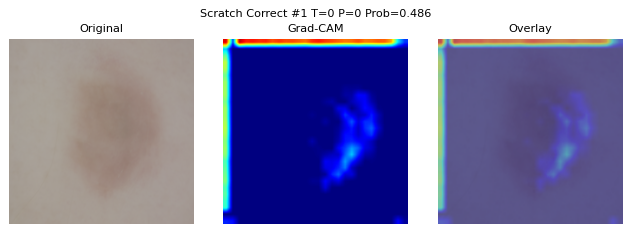

Saved: gradcam_outputs\scratch_correct_2.png


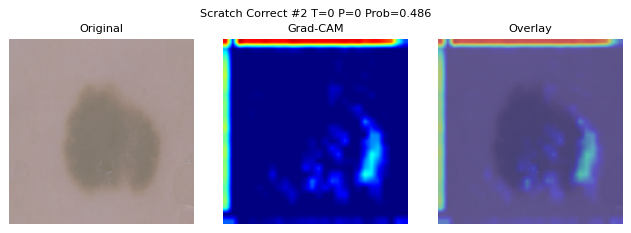

Saved: gradcam_outputs\scratch_correct_3.png


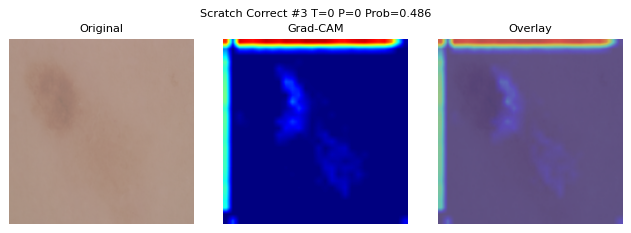

=== Scratch CNN | Wrong (3) ===
Saved: gradcam_outputs\scratch_wrong_1.png


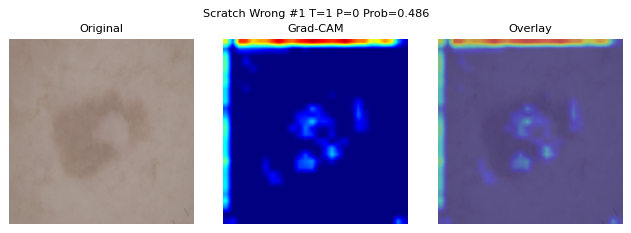

Saved: gradcam_outputs\scratch_wrong_2.png


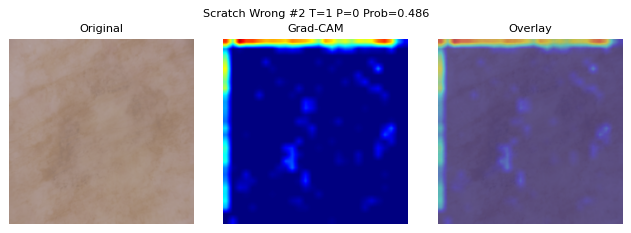

Saved: gradcam_outputs\scratch_wrong_3.png


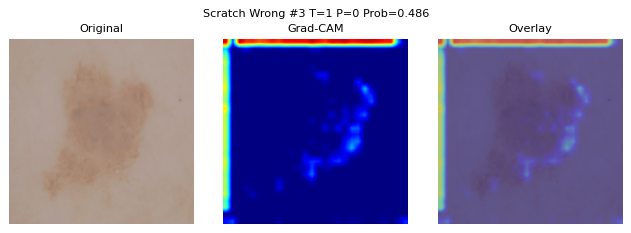

In [71]:
target_layer_scratch = model.block4[0]
gradcam_scratch = GradCAM(model, target_layer_scratch)

# Eğer daha önce aldıysan tekrar almak zorunda değilsin; ama güvenli olsun:
scratch_correct, scratch_wrong = collect_examples(model, test_loader, device, threshold=0.5, max_items=3)
print("Scratch correct:", len(scratch_correct))
print("Scratch wrong:", len(scratch_wrong))

print("=== Scratch CNN | Correct (3) ===")
for i, (img_t, ty, py, pr) in enumerate(scratch_correct, 1):
    show_triplet(
        model, gradcam_scratch, img_t, ty, py, pr,
        title_prefix=f"Scratch Correct #{i}",
        save_name=f"scratch_correct_{i}.png"
    )

print("=== Scratch CNN | Wrong (3) ===")
for i, (img_t, ty, py, pr) in enumerate(scratch_wrong, 1):
    show_triplet(
        model, gradcam_scratch, img_t, ty, py, pr,
        title_prefix=f"Scratch Wrong #{i}",
        save_name=f"scratch_wrong_{i}.png"
    )


**7.2 MobileNetV2 – Grad-CAM**

In [72]:
# MobileNetV2 target layer (son conv block)
target_layer_mnet = model_mobilenet.features[-1]
gradcam_mnet = GradCAM(model_mobilenet, target_layer_mnet)


**7.2.2 Test Setinden 3 Doğru / 3 Yanlış Örnek**

In [73]:
mnet_correct, mnet_wrong = collect_examples(
    model_mobilenet,
    test_loader,
    device,
    threshold=0.5,
    max_items=3
)

print("MobileNetV2 correct:", len(mnet_correct))
print("MobileNetV2 wrong:", len(mnet_wrong))


MobileNetV2 correct: 3
MobileNetV2 wrong: 3


**7.2.3 MobileNetV2 – Doğru Sınıflandırmalar (3 adet)**

=== MobileNetV2 | Correct (3) ===
Saved: gradcam_outputs\mobilenet_correct_1.png


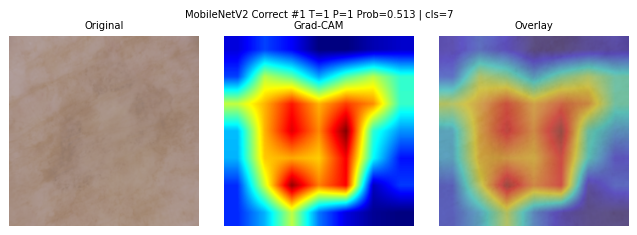

Saved: gradcam_outputs\mobilenet_correct_2.png


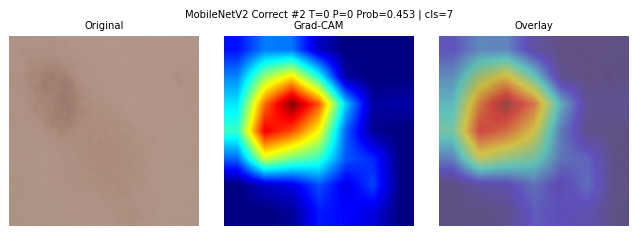

Saved: gradcam_outputs\mobilenet_correct_3.png


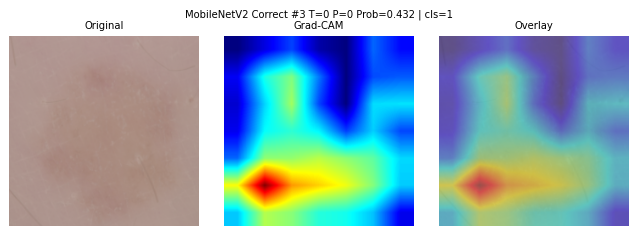

In [83]:
print("=== MobileNetV2 | Correct (3) ===")
for i, (img_t, ty, py, pr) in enumerate(mnet_correct, 1):
    show_triplet(
        model_mobilenet,
        gradcam_mnet,
        img_t,
        ty,
        py,
        pr,
        title_prefix=f"MobileNetV2 Correct #{i}",
        save_name=f"mobilenet_correct_{i}.png"
    )


**7.2.4 MobileNetV2 – Yanlış Sınıflandırmalar (3 adet)**

=== MobileNetV2 | Wrong (3) ===
Saved: gradcam_outputs\mobilenet_wrong_1.png


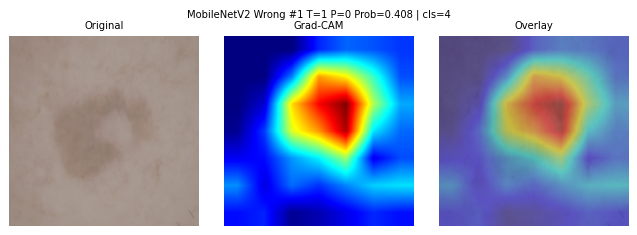

Saved: gradcam_outputs\mobilenet_wrong_2.png


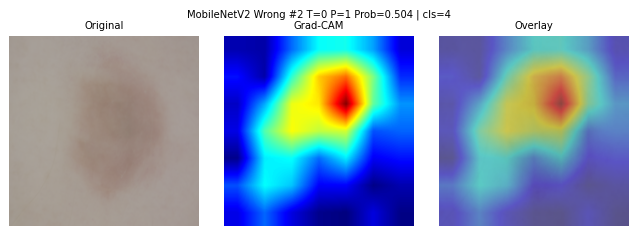

Saved: gradcam_outputs\mobilenet_wrong_3.png


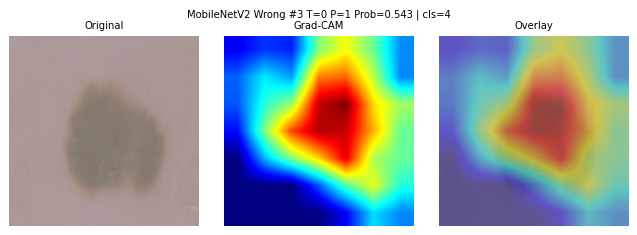

In [84]:
print("=== MobileNetV2 | Wrong (3) ===")
for i, (img_t, ty, py, pr) in enumerate(mnet_wrong, 1):
    show_triplet(
        model_mobilenet,
        gradcam_mnet,
        img_t,
        ty,
        py,
        pr,
        title_prefix=f"MobileNetV2 Wrong #{i}",
        save_name=f"mobilenet_wrong_{i}.png"
    )


**7.3.1 — EfficientNetB0: Correct/Wrong örnekleri topla (3+3)**

In [85]:
import torch
from tqdm import tqdm

def _logits_to_predprob_multiclass(logits):
    # logits: [B,C]
    probs = torch.softmax(logits, dim=1)
    pred = probs.argmax(dim=1)
    conf = probs.max(dim=1).values
    return pred, conf

@torch.no_grad()
def collect_examples_multiclass(model, dataloader, device, max_items=3):
    model.eval()
    correct, wrong = [], []

    for x, y in tqdm(dataloader, desc="Collecting examples (EffNet)", leave=False):
        x = x.to(device)
        y = y.to(device)

        out = model(x)
        if isinstance(out, (tuple, list)):
            out = out[0]

        # y shape düzelt
        if y.ndim > 1:
            y = y.view(-1)

        pred, conf = _logits_to_predprob_multiclass(out)
        pred_cpu = pred.detach().cpu()
        conf_cpu = conf.detach().cpu()
        y_cpu    = y.detach().cpu()

        for i in range(x.size(0)):
            img_cpu = x[i].detach().cpu()
            ty = int(y_cpu[i].item())
            py = int(pred_cpu[i].item())
            pr = float(conf_cpu[i].item())

            item = (img_cpu, ty, py, pr)

            if py == ty and len(correct) < max_items:
                correct.append(item)
            elif py != ty and len(wrong) < max_items:
                wrong.append(item)

            if len(correct) >= max_items and len(wrong) >= max_items:
                return correct, wrong

    return correct, wrong

# ÇALIŞTIR
eff_correct, eff_wrong = collect_examples_multiclass(model_effnet, test_loader, device, max_items=3)
print("EffNet correct:", len(eff_correct))
print("EffNet wrong  :", len(eff_wrong))
print("Example format:", "(true, pred, prob)")
if len(eff_correct) > 0:
    print("First correct:", (eff_correct[0][1], eff_correct[0][2], eff_correct[0][3]))
if len(eff_wrong) > 0:
    print("First wrong  :", (eff_wrong[0][1], eff_wrong[0][2], eff_wrong[0][3]))


EffNet correct: 3
EffNet wrong  : 3
Example format: (true, pred, prob)
First correct: (0, 0, 0.12910720705986023)
First wrong  : (1, 4, 0.15864036977291107)


**7.3.2 — EfficientNetB0 için Grad-CAM kur (target layer)**

In [86]:
import torch.nn.functional as F

# EfficientNetB0 (torchvision) için genelde son conv block:
# model_effnet.features[-1] güvenli bir seçim
target_layer_eff = model_effnet.features[-1]
gradcam_eff = GradCAM(model_effnet, target_layer_eff)

print("EffNet target layer:", target_layer_eff)


EffNet target layer: Conv2dNormActivation(
  (0): Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
)


**7.3.3 — Figür ayarları**

In [87]:
import os
import numpy as np
import matplotlib.pyplot as plt

OUT_DIR = "gradcam_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

SAVE_FIGS = True

# GitHub için küçük
FIG_W, FIG_H = 7.2, 2.2     # geniş ama kısa
FIG_DPI = 110               # düşük dpi

print("OUT_DIR:", OUT_DIR, "| FIG:", (FIG_W, FIG_H), "| DPI:", FIG_DPI)


OUT_DIR: gradcam_outputs | FIG: (7.2, 2.2) | DPI: 110


**7.3.4 — EfficientNetB0 Correct 3 görsel üret**

=== EfficientNetB0 | Correct (3) ===
Saved: gradcam_outputs\effnet_correct_1.png


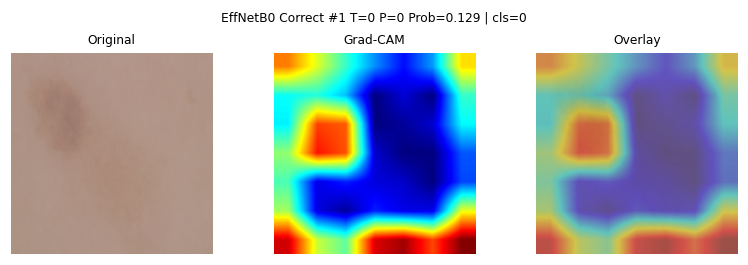

Saved: gradcam_outputs\effnet_correct_2.png


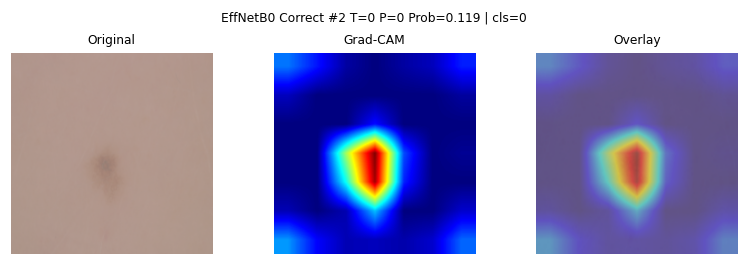

Saved: gradcam_outputs\effnet_correct_3.png


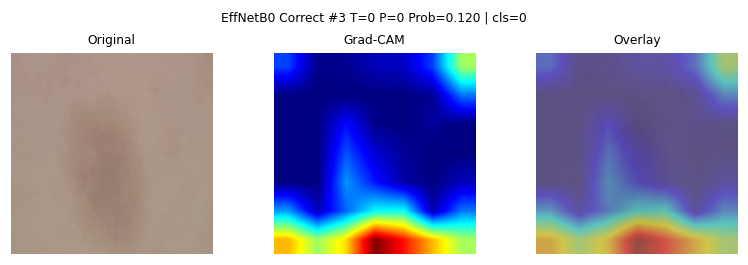

In [88]:
print("=== EfficientNetB0 | Correct (3) ===")
for i, (img_t, ty, py, pr) in enumerate(eff_correct, 1):
    show_triplet(
        model_effnet,
        gradcam_eff,
        img_t,
        ty,
        py,
        pr,
        title_prefix=f"EffNetB0 Correct #{i}",
        save_name=f"effnet_correct_{i}.png"
    )


**7.3.5 — EfficientNetB0 Wrong 3 görsel üret**

=== EfficientNetB0 | Wrong (3) ===
Saved: gradcam_outputs\effnet_wrong_1.png


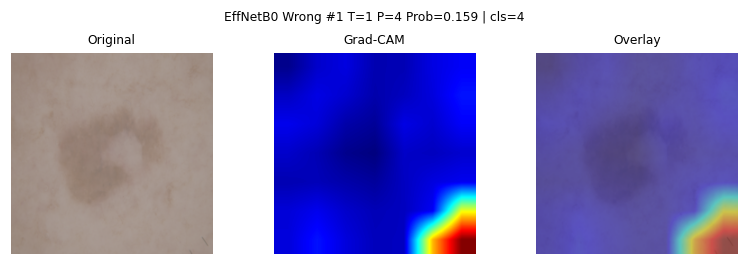

Saved: gradcam_outputs\effnet_wrong_2.png


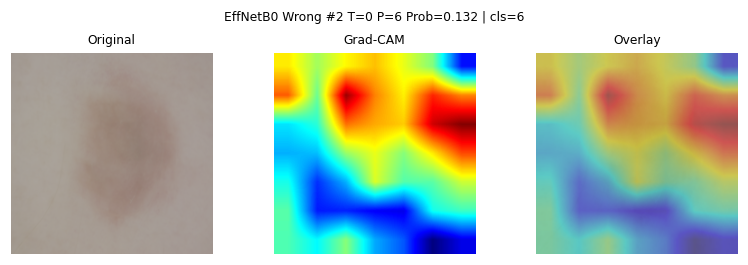

Saved: gradcam_outputs\effnet_wrong_3.png


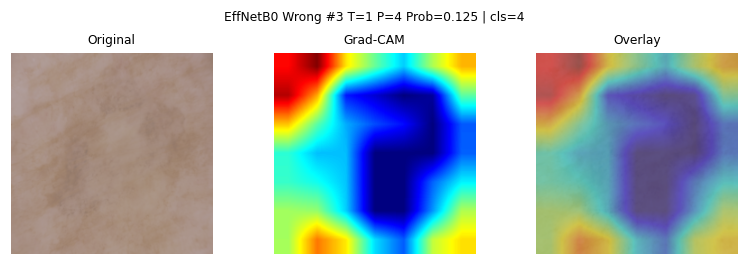

In [89]:
print("=== EfficientNetB0 | Wrong (3) ===")
for i, (img_t, ty, py, pr) in enumerate(eff_wrong, 1):
    show_triplet(
        model_effnet,
        gradcam_eff,
        img_t,
        ty,
        py,
        pr,
        title_prefix=f"EffNetB0 Wrong #{i}",
        save_name=f"effnet_wrong_{i}.png"
    )
